In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

import findspark
findspark.init() 

import pyspark
sc = pyspark.SparkContext()

In [2]:
from mnist import MNIST
mndata = MNIST('/Volumes/TRANSCEND/MNIST/python-mnist/data')
images, labels = mndata.load_training()

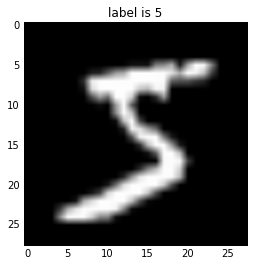

In [3]:
iimage = np.array(images[0], dtype='uint8')

plt.imshow(iimage.reshape(28,28), cmap='gray')
plt.title('label is ' + str(labels[0]))
plt.show()

In [10]:
#Build feature map
N = 5000 #How many images I want to load
d = 784 #Pixels of MNIST data
lambda_grid = [1e-4, 1e-3, 1e-2, 0, 10, 1e2]

#Choose which label you want to train
label_choose = 4




In [23]:
#Do 70/30 train/test split
#On training set, reserve 10% for cross-validation
import random
random.seed(200)
import pandas as pd
from sklearn.model_selection import train_test_split

train, test = train_test_split(np.zeros((N,d)), test_size = 0.2)
xrng = range(N)
random.shuffle(xrng)


train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [11]:
start = time.time()

full_mat = np.zeros((N,d))
ydat = []
for i in range(N): #Just do a subset of training for now
    is_label = 1*(labels[i] == label_choose)
    ydat.append(is_label)
    full_mat[i,:] = images[i]

feature_map, test = train_test_split(np.zeros((N,d)), test_size = 0.2)



#Start spark instance on points
dpoints = zip(ydat, feature_map)
points = sc.parallelize(dpoints)

#First use Spark to center the image - removes bias
x_mean = points.map(lambda x: x[1]).reduce(lambda x,y: (x+y) ) / float(N)
y_mean = np.mean(ydat)

x_c = points.map(lambda x: x[1] - x_mean).take(N)
y_c = [iy - y_mean for iy in ydat]

#Start spark instance on centered points
cpoints = sc.parallelize(zip(y_c, x_c))


###### Analytical solution to problem #######

#Do numerator first - doesn't require regularization
numer_map = cpoints.map(lambda x:x[1] * (x[0])) 
numer_sum = numer_map.reduce(lambda x,y: x+y)

#Do denominator over lambda grid
#Get analytical solution with associated error
w_stars = []
w_error = []
for ll in lambda_grid:
    denom_map = cpoints.map(lambda x: np.dot(x[1], x[1].T) + N*ll) #Need to add regularization - lambda
    denom_sum = denom_map.reduce(lambda x,y: x+y)
    iw = numer_sum / float(denom_sum)
    
    iout = np.dot(x_c, iw)
    iclass = [0 if q < 0 else 1 for q in iout]
    
    ierr = np.sum([ic == il for ic,il in zip(iclass, ydat)]) / float(N)
    
    w_stars.append(iw)
    w_error.append(ierr)
    
#Choose best solution
best_ind = np.where(w_error == np.min(w_error))[0][0]
w_star = w_stars[best_ind]
print 'Best lambda', lambda_grid[best_ind]
print 'time to train ', N, 'samples: ', time.time() - start, 'seconds'


best_pred = np.dot(x_c, w_star)
best_class = [0 if q < 0 else 1 for q in iout]
accur = np.sum([ic == il for ic,il in zip(best_class, ydat)]) / float(N)

accur

Best lambda 0.0001
time to train  5000 samples:  6.16737914085 seconds


0.66100000000000003

0.65400000000000003